## Using Built-in Processes: NDVI

### Introduction

In geospatial analysis, processing large datasets on your own laptop can be extremely time-consuming and resource-intensive. This is where openEO provides a significant advantage. OpenEO allows you to construct and execute complex calculations, known as processes, on powerful backend servers rather than on your local machine. This approach frees up your resources and ensures that heavy computations are handled efficiently.

One aspect that might initially confuse new users is the recursive nature of the term "process" in openEO. A process in openEO can consist of other processes, forming what is known as a process tree. In a process tree, data flows from one process to another, often starting with the creation of data cubes using the `load_collection` process. This is a process you've already encountered in previous exercises, though we hadn't explicitly referred to it as a process. The process tree typically culminates in the `save_result` process, which stores or outputs the final data product.

In previous exercises, we connected the `load_collection` process directly to the `save_result` process, essentially loading the data and saving it without any intermediate steps. However, in this notebook, we'll take it a step further by performing some analysis between these steps. Specifically, we'll introduce the use of built-in processes, such as the Normalized Difference Vegetation Index (NDVI), to analyze the data before saving the results.

This approach not only showcases the flexibility of openEO's process trees but also highlights how you can insert analytical steps between data loading and saving to gain insights from your data. By offloading the heavy computation to the backend, openEO allows you to focus on building and analyzing your process trees without the burden of processing on your local machine.

In this notebook, we will demonstrate how to use a built-in process, emphasizing that all heavy computation is handled by the backend, freeing up your local resources.

### Objective

The objective of this tutorial is to show you how to leverage openEO to perform NDVI calculations, highlighting the advantage of offloading processing tasks to the backend. We will guide you through the steps of building a process graph using the openEO Python client, which communicates with the backend to perform the computations. This allows you to work efficiently with large datasets, focusing on analysis rather than computation.

### In this notebook, you will explore the following concepts:

A. **Exploring Available Processes**: Understand how to list and explore the available processes in the openEO backend, focusing on identifying the NDVI process.

B. **Loading Data**: Load satellite data into a data cube that can be processed.

C. **Building and Executing the NDVI Process**: Use the built-in NDVI process to create a process graph that calculates NDVI, and execute this process on the backend.

D. **Visualizing the NDVI Results**: Visualize the NDVI output to ensure the process has been executed correctly, using custom helper functions for rendering.

### Tools You'll Use:

- **openEO**: To interact with satellite data and perform spatial operations.
- **Matplotlib via demo_helpers**: We use our own helper function to visualize the result. Look into `demo_helpers.py`if you are curious.

### Learning Outcomes:

By the end of this tutorial, you will be able to:

- Connect to an openEO backend and load satellite data into a processable format.
- Explore and understand the available processes within the openEO backend.
- Build and execute a process graph to calculate NDVI.
- Visualize and verify the NDVI results to ensure accurate analysis.

This approach allows you to utilize the robust processing capabilities of the openEO backend, enabling you to efficiently analyze large datasets without burdening your local computing resources.


## Establishing a Connection
First, we'll establish a connection to the openEO backend and authenticate using the provided credentials. 

In [22]:
import openeo
from config import user,passwd,eo_service_url
from demo_helpers import show_result
from demo_regions import s2

# a. connect to the openeo back-end
conn = openeo.connect(eo_service_url)
conn.authenticate_basic(username= user, password=passwd)




<Connection to 'https://openeo.digitalearth.se/' with BasicBearerAuth>

### A. Exploring Available Processes

Before performing any calculations, it's essential to understand what processes are available in the openEO backend. The openEO client can request a list of built-in processes from the connected backend, allowing you to see the variety of operations you can perform on your data.

In this example, we'll focus on the `NDVI` process, which calculates the Normalized Difference Vegetation Index—a key indicator used to analyze vegetation health and density. By exploring the details of the `NDVI` process, we can understand the required inputs and how to properly configure our data for accurate results.

#### Understanding the `NDVI` Process

The `NDVI` process computes the ratio between the near-infrared (NIR) and red portions of the electromagnetic spectrum reflected by vegetation. This ratio highlights the presence and condition of live green vegetation, making it widely used in agriculture, forestry, and environmental monitoring.

**Inputs Required by the `NDVI` Process:**
- `nir`: The near-infrared band of your satellite imagery.
- `red`: The red band of your satellite imagery.

#### What are the `nir` and `red` Bands?

- **`nir` (Near-Infrared Band):**
  - This band captures light wavelengths typically between 841–876 nanometers.
  - Healthy vegetation strongly reflects NIR light due to the internal structure of their leaves.
  - High reflectance in the NIR band indicates dense and healthy vegetation.

- **`red` (Red Band):**
  - This band captures light wavelengths typically between 620–670 nanometers.
  - Chlorophyll in plants absorbs red light for photosynthesis, so healthy vegetation reflects less red light.
  - Low reflectance in the red band indicates healthy and photosynthetically active vegetation.


In [23]:
conn.list_processes()

[{'id': 'absolute',
  'summary': 'Absolute value',
  'description': 'Computes the absolute value of a real number `x`, which is the "unsigned" portion of x and often denoted as *|x|*.\n\nThe no-data value `null` is passed through and therefore gets propagated.',
  'categories': ['math'],
  'parameters': [{'name': 'x',
    'description': 'A number.',
    'schema': {'type': ['number', 'null'],
     'minItems': 0.0,
     'deprecated': False}}],
  'returns': {'description': 'The computed absolute value.',
   'schema': {'type': ['number', 'null']}},
  'examples': [{'arguments': {'x': 0}, 'returns': 0},
   {'arguments': {'x': 3.5}, 'returns': 3.5},
   {'arguments': {'x': -0.4}, 'returns': 0.4},
   {'arguments': {'x': -3.5}, 'returns': 3.5}],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/AbsoluteValue.html',
    'title': 'Absolute value explained by Wolfram MathWorld'}],
  'process_graph': {'lt': {'process_id': 'lt',
    'result': False,
    'arguments': {'x': {'from_parameter': 'x'}, 'y': 0}},
   'multiply': {'process_id': 'multiply',
    'result': False,
    'arguments': {'x': {'from_parameter': 'x'}, 'y': -1}},
   'if': {'process_id': 'if',
    'result': True,
    'arguments': {'value': {'from_node': 'lt'},
     'accept': {'from_node': 'multiply'},
     'reject': {'from_parameter': 'x'}}}}},
 {'id': 'add_dimension',
  'summary': 'Add a new dimension',
  'description': 'Adds a new named dimension to the data cube.\n\nAfterwards, the dimension can be referred to with the specified `name`. If a dimension with the specified name exists, the process fails with a `DimensionExists` exception. The dimension label of the dimension is set to the specified `label`.',
  'categories': ['cubes'],
  'parameters': [{'name': 'data',
    'description': 'A data cube to add the dimension to.',
    'schema': {'type': 'object',
     'subtype': 'raster-cube',
     'minItems': 0.0,
     'deprecated': False}},
   {'name': 'name',
    'description': 'Name for the dimension.',
    'schema': {'type': 'string', 'minItems': 0.0, 'deprecated': False}},
   {'name': 'label',
    'description': 'A dimension label.',
    'schema': [{'type': 'number', 'minItems': 0.0, 'deprecated': False},
     {'type': 'string', 'minItems': 0.0, 'deprecated': False}]},
   {'name': 'type',
    'description': 'The type of dimension, defaults to `other`.',
    'optional': True,
    'default': 'other',
    'schema': {'type': 'string',
     'enum': ['spatial', 'temporal', 'bands', 'other'],
     'minItems': 0.0,
     'deprecated': False}}],
  'returns': {'description': 'The data cube with a newly added dimension. The new dimension has exactly one dimension label. All other dimensions remain unchanged.',
   'schema': {'type': 'object'}},
  'exceptions': {'DimensionExists': {'message': 'A dimension with the specified name already exists.',
    'http': 400}}},
 {'id': 'add',
  'summary': 'Addition of two numbers',
  'description': 'Sums up the two numbers `x` and `y` (*`x + y`*) and returns the computed sum.\n\nNo-data values are taken into account so that `null` is returned if any element is such a value.\n\nThe computations follow [IEEE Standard 754](https://ieeexplore.ieee.org/document/8766229) whenever the processing environment supports it.',
  'categories': ['math'],
  'parameters': [{'name': 'x',
    'description': 'The first summand.',
    'schema': {'type': ['number', 'null'],
     'minItems': 0.0,
     'deprecated': False}},
   {'name': 'y',
    'description': 'The second summand.',
    'schema': {'type': ['number', 'null'],
     'minItems': 0.0,
     'deprecated': False}}],
  'returns': {'description': 'The computed sum of the two numbers.',
   'schema': {'type': ['number', 'null']}},
  'examples': [{'arguments': {'x': 5, 'y': 2.5}, 'returns': 7.5},
   {'arguments': {'x': -2, 'y': -4}, 'returns': -6},
   {'arguments': {'x': 1, 'y': None}}],
  'links': [{'rel': 'about',
    'href': 'http://mathworld.wolfram.com/Sum.html',
    'title': 'Sum explained by Wo

Now lets run some code for loading data, applying the selected process on the data and finally viewing the data. The individual steps will be explain in the cells below.

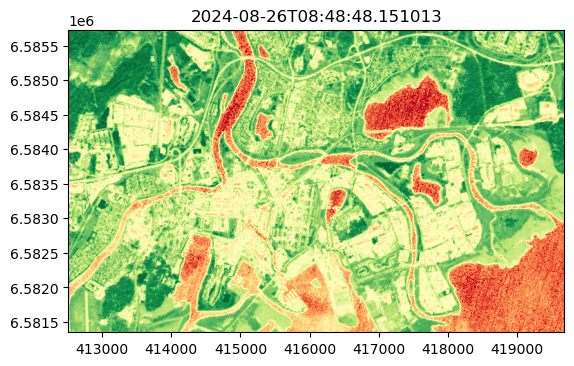

In [24]:
# B. Loading the data
cube=conn.load_collection(s2.s2_msi_l2a,
                         spatial_extent=s2.bbox.karlstad_mini_land,
                         temporal_extent=s2.timespans.one_image,
                         bands=['b04','b08'])
# C.Building and Executing the NDVI Process
res =cube.ndvi(nir="b08",red="b04").download(format="gtiff")
# D. Visulizing the result
_ = show_result(res,is_ndvi=True)

## B. Loading the data
Now we need to prepare a data cube that will load relevant example data that can be used in our NDVI process. 
In the example below we have selected a small region and a tight time-span to get a manageable amount of data to work with. 
- **Spatial Extent** (`spatial_extent=s2.bbox.karlstad_mini_land`):<br>
We specify a region of interest over Sweden, focusing on a pre-defined area around Karlstad.
This area is small enough to process efficiently while still providing meaningful data for analysis.

- **Temporal Extent** (`temporal_extent=s2.timespans.one_image`):<br>
The temporal extent is set to a specific time span that corresponds to a single observation date.
This ensures that the data cube contains only one time step for each band, simplifying the analysis and focusing on a specific moment in time.

- **Bands** (`bands=['b04', 'b08']`):
    - Band 4 (b04): This band corresponds to required "red" band. 
    - Band 8 (b08): This band corresponds to the near-infrared (NIR)
 
Once the data cube is created with the correct parameters, we can proceed with building the NDVI process.
## C. Building and Executing the NDVI Process
Now that we have the data "loaded", we can proceed to build the NDVI process. The openEO client constructs a process graph, which is then executed by the backend server, ensuring that all computation happens remotely. The `cube.ndvi(nir="b08",red="b04")` adds the `ndvi` process to the datacube `cube`. The `.download(format="gtiff")` makes sure the resulting process tree is sent to the back end for execution, putting the result in the variable `res`. 
## D. Visualizing the NDVI Results
The `show_result` function is provided with the demo notebooks and is a cheat for you to quickly view the result. Take a look into the `demo_helpers.py` if you are curious. We will talk more about how you can do your own visualization later on. The first argument is the result from the back-end (`res`) and the second tells the function to use colors that shows an NDVI result in a nice way. 

**Interpreting NDVI Values:**
- Values range from **-1 to 1**.
  - **Close to 1**: Indicates dense, healthy vegetation.
  - **Around 0**: Indicates barren areas of rock, sand, or snow.
  - **Negative values**: Indicate water bodies, clouds, or snow.

Now you know a bit how to browse and use the built-in functions of OpenEO!